In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timezone, timedelta
from io import StringIO
import geohash2
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math
# Gloabl seaborn Theme
sns.set_theme(style="whitegrid", palette="pastel")

# Extraction - PM25 Raw

In [2]:
# Time Period to Calculate NowCast AQI
#
# AQICN: https://aqicn.org/faq/2015-03-15/air-quality-nowcast-a-beginners-guide/
# AirNow: http://airnow.gov/
# NowCast: https://en.wikipedia.org/wiki/NowCast_(air_quality_index)
#
#
parameters = catalog.load('parameters')
# Current DateTime
nowcast_datetime = parameters['nowcast_datetime']
nowcast_timestamp = int(datetime.fromisoformat(nowcast_datetime).timestamp() * 1000)
# Start DateTime
start_datetime = (datetime.fromisoformat(nowcast_datetime) - timedelta(hours=24)).isoformat()
start_timestamp = int(datetime.fromisoformat(start_datetime).timestamp() * 1000)

print(
    'nowcast_datetime:', nowcast_datetime,
    'timestamp:', nowcast_timestamp,
    ':: start_datetime:', start_datetime,
    'timestamp:', start_timestamp
)

2022-09-10 12:33:27,320 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...
nowcast_datetime: 2022-09-06T13:35:00 timestamp: 1662489300000 :: start_datetime: 2022-09-05T13:35:00 timestamp: 1662402900000


In [3]:
# Request to InfluxDB API REST
def request_to_influxdb(sql_query):
    endpoint = "http://influxdb.canair.io:8086/query"
    database = "canairio"
    parameters = {
        'db': database,
        'q': sql_query,
        'epoch': 'ms'
    }
    # To get response as CSV text
    headers = {'Accept': 'application/csv'}
    # GET Request
    return requests.get(endpoint, params=parameters, headers=headers)

In [4]:
# Get SQL Query Tangaras
def get_sql_query_tangaras(start_datetime, end_datetime):
    sql_query = ""
    # Period DateTime
    period_time = f"time >= {start_datetime}ms AND time <= {end_datetime}ms"
    # SQL
    sql_query = "SELECT DISTINCT(geo) AS \"geohash\" "\
                "FROM \"fixed_stations_01\" WHERE "\
                    "(\"geo3\" = 'd29') AND "\
                    f"{period_time} "\
                "GROUP BY \"name\";"
    return sql_query

In [5]:
# SQL Query Tangaras
sql_query = get_sql_query_tangaras(start_timestamp, nowcast_timestamp)
print(sql_query)

SELECT DISTINCT(geo) AS "geohash" FROM "fixed_stations_01" WHERE ("geo3" = 'd29') AND time >= 1662402900000ms AND time <= 1662489300000ms GROUP BY "name";


In [6]:
# Get Data Frame Tangaras
def get_df_tangaras(start_datetime, end_datetime):
    # SQL Query Tangaras
    sql_query = get_sql_query_tangaras(start_datetime, end_datetime)
    # InfluxDB API REST Request
    influxdb_api_request = request_to_influxdb(sql_query)
    #print(influxdb_api_request)
    df_tangaras = pd.read_csv(StringIO(influxdb_api_request.text), sep=",")
    
    # Remove/Add Columns
    df_tangaras = df_tangaras[['tags', 'geohash']]
    df_tangaras['MAC'] = df_tangaras['tags'].apply(lambda x: x.split('=')[1])
    df_tangaras['GEOLOCATION'] = df_tangaras['geohash'].apply(lambda x: " ".join(str(value) for value in list(geohash2.decode_exactly(x)[0:2])))
    df_tangaras['LATITUDE'] = df_tangaras['GEOLOCATION'].apply(lambda x: x.split(' ')[0])
    df_tangaras['LONGITUDE'] = df_tangaras['GEOLOCATION'].apply(lambda x: x.split(' ')[1])
    df_tangaras['tags'] = df_tangaras['tags'].apply(lambda x: f"TANGARA_{x[-4:]}")
    df_tangaras.rename(columns={'tags': 'ID', 'geohash': 'GEOHASH'}, inplace=True)
    # Date time when query is executed
    tz = timezone(timedelta(hours=-5))
    df_tangaras['DATETIME'] = datetime.now(tz=tz)

    return df_tangaras

In [7]:
# Data Frame Tangaras
tangaras = get_df_tangaras(start_timestamp, nowcast_timestamp)
tangaras.head()

,ID,GEOHASH,MAC,GEOLOCATION,LATITUDE,LONGITUDE,DATETIME
0,TANGARA_2BBA,d29e6b4,D29ESP32DE02BBA,3.3844757080078125 -76.51634216308594,3.3844757080078125,-76.51634216308594,2022-09-10 12:33:29.002640-05:00
1,TANGARA_14D6,d29dfx4,D29ESP32DED14D6,3.3350372314453125 -76.52732849121094,3.3350372314453125,-76.52732849121094,2022-09-10 12:33:29.002640-05:00
2,TANGARA_1CE2,d29e4cv,D29ESP32DED1CE2,3.3501434326171875 -76.51222229003906,3.3501434326171875,-76.51222229003906,2022-09-10 12:33:29.002640-05:00
3,TANGARA_1FCA,d29e48s,D29ESP32DED1FCA,3.3432769775390625 -76.52458190917969,3.3432769775390625,-76.52458190917969,2022-09-10 12:33:29.002640-05:00
4,TANGARA_2492,d29e64g,D29ESP32DED2492,3.3995819091796875 -76.54792785644531,3.3995819091796875,-76.54792785644531,2022-09-10 12:33:29.002640-05:00


In [8]:
# Save tangaras into Catalog
catalog.save('tangaras', tangaras)

2022-09-10 12:33:29,170 - kedro.io.data_catalog - INFO - Saving data to `tangaras` (CSVDataSet)...


In [9]:
# Get SQL Query Data Sensors
def get_sql_query_sensors(tangaras, start_datetime, end_datetime):
    sql_query = ""
    # Period DateTime
    period_time = f"time >= {start_datetime}ms AND time <= {end_datetime}ms"
    # SQL
    for mac in tangaras['MAC'].to_list():
        sql_query += "SELECT \"name\", last(\"pm25\") "\
                    "FROM \"fixed_stations_01\" WHERE "\
                    f"(\"name\" = '{mac}') AND "\
                    f"{period_time} " \
                    "GROUP BY time(30s) fill(none); "
    return sql_query[:-2]

In [10]:
# SQL Query Data Sensors
sql_query = get_sql_query_sensors(tangaras, start_timestamp, nowcast_timestamp)
#print(sql_query)

In [11]:
# Get Data Frame Sensors
def get_df_sensors(tangaras, start_datetime, end_datetime):
    # Data Frame Sensors
    df_sensors = []
    # SQL Query Data Sensors
    sql_query = get_sql_query_sensors(tangaras, start_datetime, end_datetime)
    # InfluxDB API REST Request
    influxdb_api_request = request_to_influxdb(sql_query)
    #print(influxdb_api_request)
    df_influxdb_api_sensors = pd.read_csv(StringIO(influxdb_api_request.text), sep=",")

    # Remove/Add Columns
    df_influxdb_api_sensors = df_influxdb_api_sensors[['time', 'name.1', 'last']]
    df_influxdb_api_sensors.rename(columns={'time': 'DATETIME', 'name.1': 'MAC', 'last': 'PM25'}, inplace=True)

    # Truncate Response
    for index, row in tangaras.iterrows():
        df_sensor = df_influxdb_api_sensors.loc[df_influxdb_api_sensors['MAC'] == row['MAC']].reset_index(drop=True)[['DATETIME', 'PM25']] # Warning
        if not df_sensor.empty:
            df_sensor.rename(columns={'PM25': row['ID']}, inplace=True)
            df_sensor.set_index('DATETIME', inplace=True)
            df_sensors.append(df_sensor)
    
    df_sensors = df_sensors[0].join(df_sensors[1:]).reset_index()

    tz = timezone(timedelta(hours=-5))
    df_sensors['DATETIME'] = df_sensors['DATETIME'].apply(lambda x: datetime.fromtimestamp(int(x) / 1000, tz=tz).isoformat())

    df_sensors[df_sensors.columns.to_list()[1:]] = df_sensors[df_sensors.columns.to_list()[1:]].astype('Int64')
    
    return df_sensors

In [12]:
# Data Frame Sensors
pm25_raw = get_df_sensors(tangaras, start_timestamp, nowcast_timestamp)
pm25_raw.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05T13:35:00-05:00,21,20,24,26,25,26,16,7,21,34,26,25,25
1,2022-09-05T13:35:30-05:00,20,20,23,25,24,25,15,7,19,42,26,25,26
2,2022-09-05T13:36:00-05:00,20,20,24,166,23,26,16,8,18,39,27,25,24
3,2022-09-05T13:36:30-05:00,21,20,24,64,25,24,16,8,19,36,29,25,24
4,2022-09-05T13:37:00-05:00,22,22,24,49,26,26,14,7,19,39,29,26,23


In [13]:
# Check Data Types
pm25_raw.dtypes

DATETIME        object
TANGARA_2BBA     Int64
TANGARA_14D6     Int64
TANGARA_1CE2     Int64
TANGARA_1FCA     Int64
TANGARA_2492     Int64
TANGARA_2FF6     Int64
TANGARA_48C6     Int64
TANGARA_4D7A     Int64
TANGARA_532E     Int64
TANGARA_EA06     Int64
TANGARA_F1AE     Int64
TANGARA_FAC6     Int64
TANGARA_06BE     Int64
dtype: object

## Descriptive Statistics

In [14]:
# Describe Data
pm25_raw.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2838.000000,2747.000000,2796.000000,842.000000,2779.000000,2801.000000,2807.000000,2763.000000,2692.000000,2755.000000,2770.000000,2739.000000,2793.000000
mean,21.417195,24.116491,25.281474,38.681710,27.880533,26.601928,16.470609,5.638075,16.235884,32.560436,28.472924,21.766338,25.704261
std,5.746803,5.982577,6.981280,59.070996,11.151621,5.989012,6.511554,2.852142,8.509186,20.869400,12.251082,15.567362,5.954451
min,10.000000,12.000000,12.000000,23.000000,13.000000,14.000000,0.000000,2.000000,3.000000,9.000000,11.000000,9.000000,15.000000
25%,17.000000,20.000000,21.000000,27.000000,23.000000,22.000000,11.000000,3.000000,8.000000,15.000000,17.000000,11.000000,21.000000
50%,21.000000,23.000000,25.000000,29.000000,26.000000,26.000000,17.000000,5.000000,15.000000,29.000000,29.000000,20.000000,25.000000
75%,25.000000,28.000000,30.000000,31.000000,31.000000,30.000000,21.000000,8.000000,24.000000,48.000000,39.000000,31.000000,30.000000
max,44.000000,72.000000,56.000000,1110.000000,182.000000,42.000000,60.000000,12.000000,86.000000,583.000000,170.000000,449.000000,51.000000


In [15]:
# Plot Histograms
def histplots(data_sensors):
    # Canvas
    fig, axes = plt.subplots(4, 4, figsize=(22, 16), constrained_layout=True)
    fig.suptitle('Histograms - Data Sensors', fontsize=20)
    # Plot
    size = len(data_sensors.describe().columns)
    k = 1
    for i in range(0, 4):
        for j in range(0, 4):
            if k <= size:
                sns.histplot(ax=axes[i, j], data=data_sensors[data_sensors.columns[k]])
            k += 1

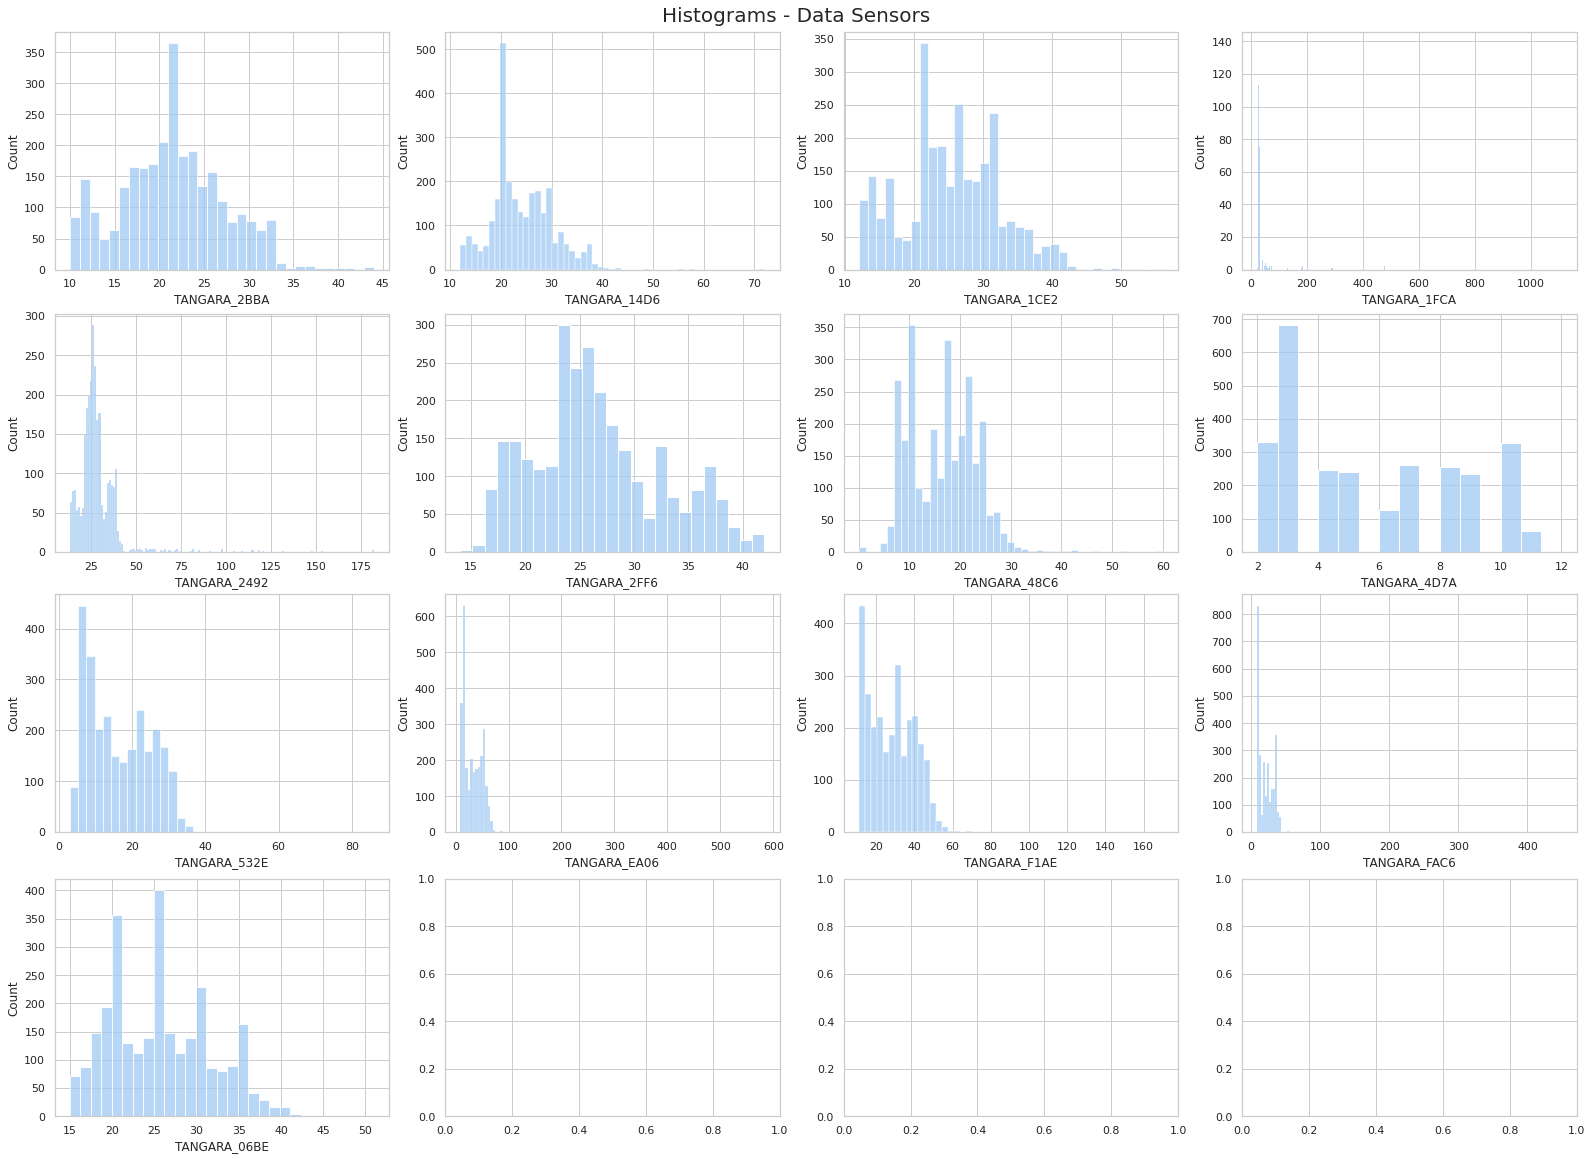

In [16]:
# Plot Histograms
histplots(pm25_raw)

In [17]:
# Plot Boxplots
def boxplots(data_sensors):
    # Canvas
    fig, axes = plt.subplots(4, 4, figsize=(22, 16), constrained_layout=True)
    fig.suptitle('Boxplots - Data Sensors', fontsize=20)
    # Plot
    size = len(data_sensors.describe().columns)
    k = 1
    for i in range(0, 4):
        for j in range(0, 4):
            if k <= size:
                sns.boxplot(ax=axes[i, j], data=data_sensors[data_sensors.columns[k]], orient="h", x=data_sensors[data_sensors.columns[k]])
            k += 1

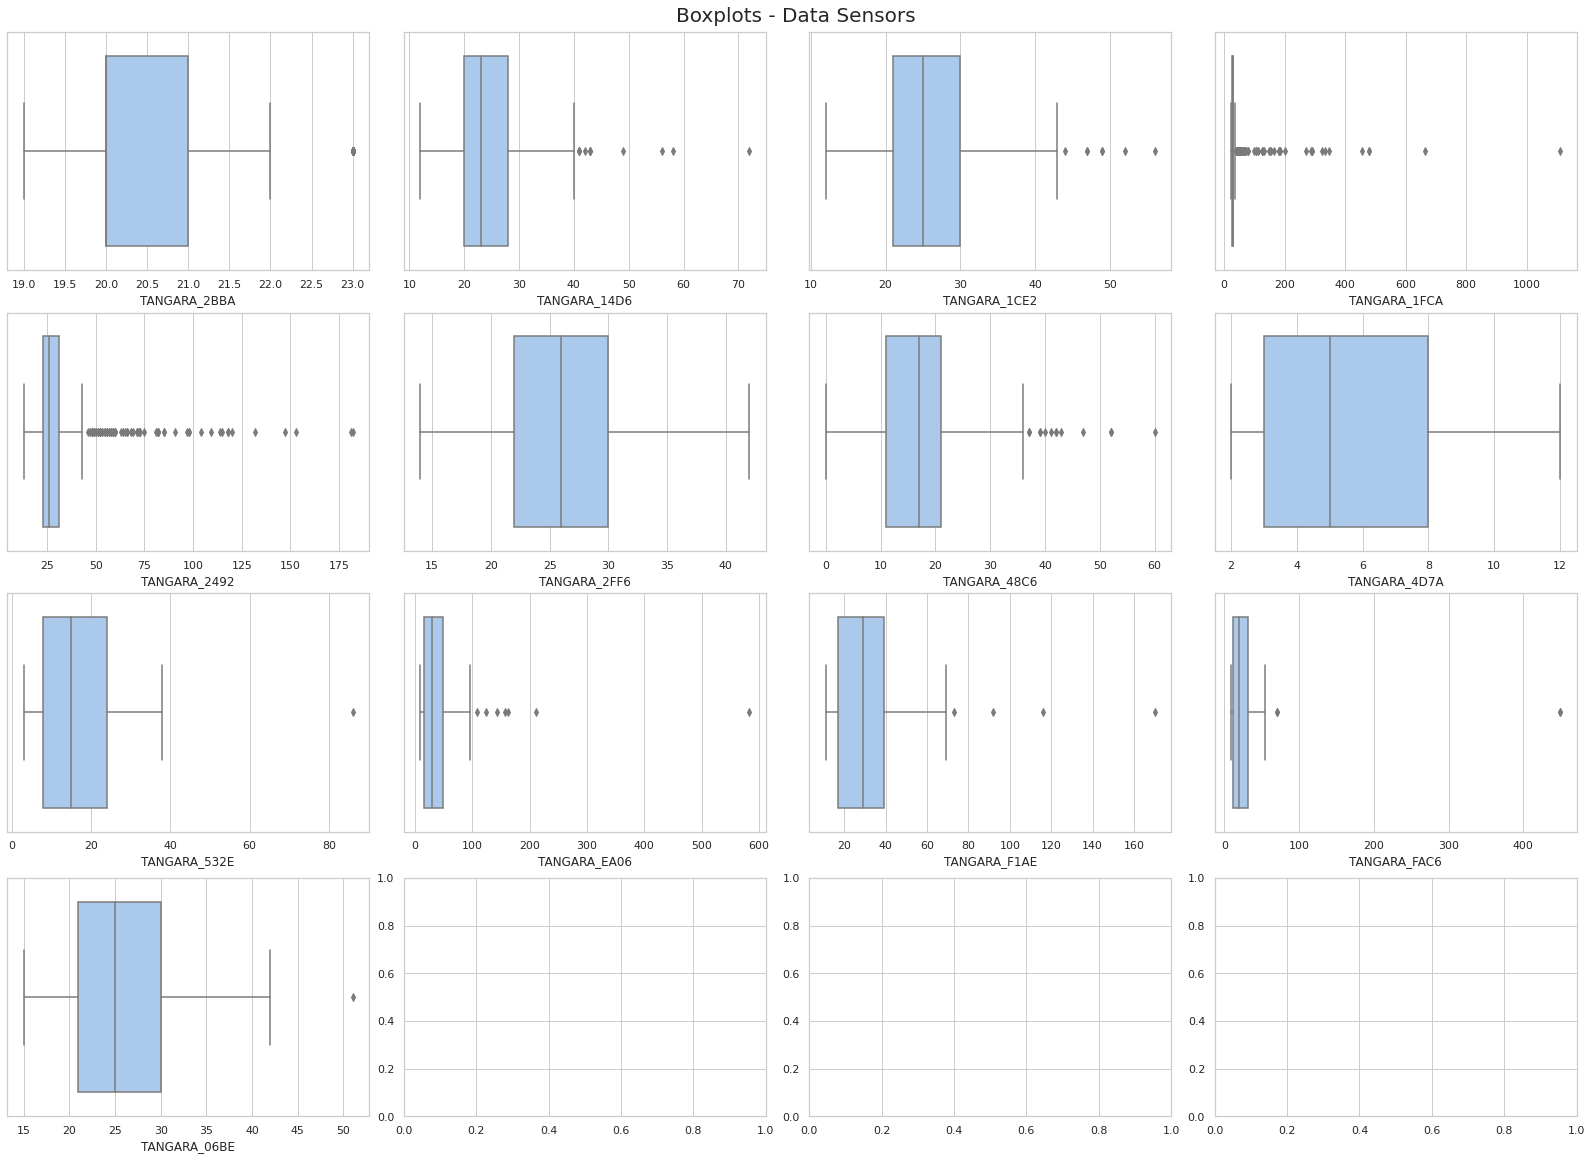

In [18]:
# Plot Boxplots
boxplots(pm25_raw)

In [19]:
# Plot Lineplots
def lineplots(data_sensors):
    fig, axes = plt.subplots(4, 4, figsize=(22, 16), constrained_layout=True)

    fig.suptitle('Timeline - Data Sensors', fontsize=20)

    size = len(data_sensors.describe().columns)
    k = 1
    for i in range(0, 4):
        for j in range(0, 4):
            if k <= size:
                sns.lineplot(ax=axes[i, j], data=data_sensors[data_sensors.columns[k]])
            k += 1

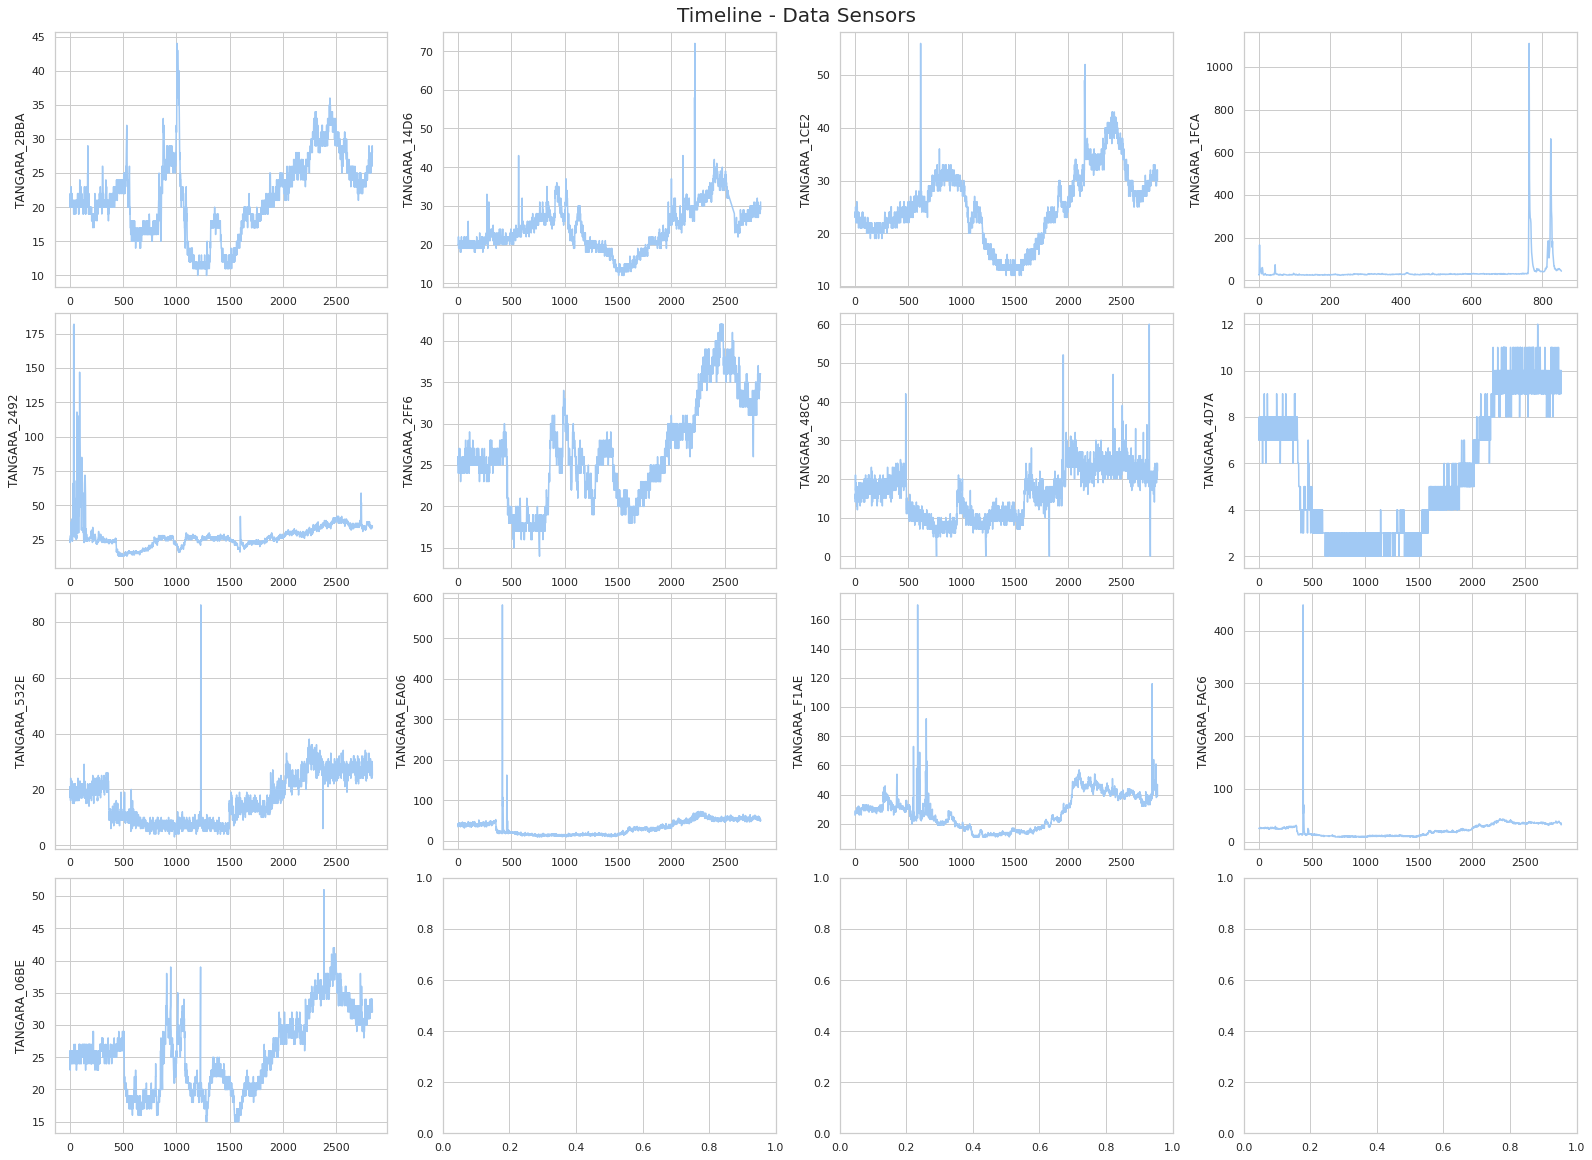

In [20]:
# Plot Lineplots
lineplots(pm25_raw)

In [21]:
# Save pm25_raw into Catalog
catalog.save('pm25_raw', pm25_raw)

2022-09-10 12:34:18,752 - kedro.io.data_catalog - INFO - Saving data to `pm25_raw` (CSVDataSet)...
